In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('hw6.ok')

Assignment: hw6
OK, version v1.13.11



# Homework 6: Predicting Housing Prices (Continued)

## Due Date: 11:59pm Monday, April 6

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the collaborators cell below.

**Collaborators:** *write names here*

## Introduction

This assignment will continue from where we left off in in Homework 5. Recall that the linear model that you created failed to produce accurate estimates of the observed housing prices because the model was too simple. The goal of this homework is to guide you through the iterative process of specifying, fitting, and analyzing the performance of more complex linear models used to predict prices of houses in Ames, Iowa. Additionally, you will have the opportunity to choose your own features and create your own regression model!

By the end of this homework, you should feel comfortable:

1. Identifying informative variables through EDA
2. Feature engineering categorical variables
3. Using sklearn to build more complex linear models

## Score Breakdown

Question | Points
--- | ---
[Question 1a](#q1a) | 1
[Question 1b](#q1b) | 1
[Question 1c](#q1c) | 1
[Question 2a](#q2a) | 1
[Question 2b](#q2b) | 2
[Question 3a](#q3a) | 1
[Question 3b](#q3b) | 2
[Question 3c](#q3c) | 1
[Question 3d](#q3d) | 1
[Question 4](#q4) | 6
[Question 5a](#q5a) | 2
[Question 5b](#q5b) | 2
Total | 22

In [2]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# The Data

As a reminder, the [Ames dataset](http://jse.amstat.org/v19n3/decock.pdf) consists of 2930 records taken from the Ames, Iowa, Assessor’s Office describing houses sold in Ames from 2006 to 2010.  The data set has 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers) --- 82 features in total.  An explanation of each variable can be found in the included `codebook.txt` file.  The information was used in computing assessed values for individual residential properties sold in Ames, Iowa from 2006 to 2010.

The raw data are split into training and test sets with 2000 and 930 observations, respectively. To save some time, we've used a slightly modified data cleaning pipeline from last week's assignment to prepare the training data. This data is stored in `ames_train_cleaned.csv`. It consists of 1998 observations and 83 features (we added TotalBathrooms from Homework 5). 

In [4]:
training_data = pd.read_csv("ames_train_cleaned.csv")

# Part 4: More Feature Selection and Engineering

In this section, we identify two more features of the dataset that will increase our linear regression model's accuracy. Additionally, we will implement one-hot encoding so that we can include binary and categorical variables in our improved model.

## Question 1: Neighborhood vs Sale Price

First, let's take a look at the relationship between neighborhood and sale prices of the houses in our data set.

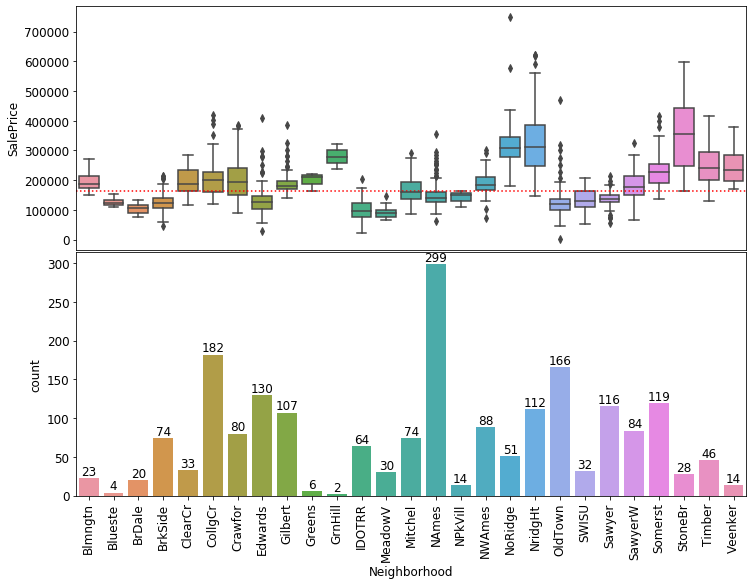

In [5]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[0]
)

sns.countplot(
    x='Neighborhood',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=training_data['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

### Question 1a <a name="q1a"></a> 

Based on the plot above, what can be said about the relationship between the houses' sale prices and their neighborhoods?

<!--
BEGIN QUESTION
name: q1a
points: 1
manual: True
-->
<!-- EXPORT TO PDF -->

Based on the plot above we can say that there is quite a variation in houses' sale prices depending on the neighborhood where the house is located. Additionally, the data is not uniformly distributed as there are a lot of houses in the North Ames neighborhood and less houses in other neighborhoods.

### Question 1b <a name="q1b"></a> 

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  Let's categorize our neighborhoods in a crude way: we'll take the top 3 neighborhoods measured by median `SalePrice` and identify them as "rich neighborhoods"; the other neighborhoods are not marked.

Write a function that returns list of the top n most pricy neighborhoods as measured by our choice of aggregating function.  For example, in the setup above, we would want to call `find_rich_neighborhoods(training_data, 3, np.median)` to find the top 3 neighborhoods measured by median `SalePrice`.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [6]:
def find_rich_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    neighborhoods = data.groupby("Neighborhood", as_index=False)["SalePrice"].agg(metric).sort_values(by="SalePrice", ascending=False)
    neighborhoods = neighborhoods.iloc[:n]["Neighborhood"].tolist()
    return neighborhoods

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
rich_neighborhoods

['StoneBr', 'NridgHt', 'NoRidge']

In [7]:
ok.grade("q1b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 5
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1c <a name="q1c"></a> 

We now have a list of neighborhoods we've deemed as richer than others.  Let's use that information to make a new variable `in_rich_neighborhood`.  Write a function `add_rich_neighborhood` that adds an indicator variable which takes on the value 1 if the house is part of `rich_neighborhoods` and the value 0 otherwise.

**Hint:** [`pd.Series.astype`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Series.astype.html) may be useful for converting True/False values to integers.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q1c
points: 1
-->

In [8]:
def add_in_rich_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """
    data['in_rich_neighborhood'] = data["Neighborhood"].isin(neighborhoods).astype("int32")
    return data

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)

In [9]:
ok.grade("q1c");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



## Question 2: Fireplace Quality

In the following question, we will take a closer look at the Fireplace_Qu feature of the dataset and examine how we can incorporate categorical features into our linear model.

### Question 2a <a name="q2a"></a>

Let's see if our data set has any missing values.  Create a Series object containing the counts of missing values in each of the columns of our data set, sorted from greatest to least.  The Series should be indexed by the variable names.  For example, `missing_counts['Fireplace_Qu']` should return 975.

**Hint:** [`pandas.DataFrame.isnull`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isnull.html) may help here.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q2a
points: 1
-->

In [10]:
missing_counts = training_data.isnull().sum().sort_values(ascending=False)
missing_counts

Pool_QC            1991
Misc_Feature       1922
Alley              1865
Fence              1607
Fireplace_Qu        975
                   ... 
Low_Qual_Fin_SF       0
2nd_Flr_SF            0
1st_Flr_SF            0
Central_Air           0
Order                 0
Length: 84, dtype: int64

In [11]:
ok.grade("q2a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 5
    Failed: 0
[ooooooooook] 100.0% passed



It turns out that if we look at the codebook carefully, some of these "missing values" aren't missing at all! The Assessor's Office just used `NA` to denote a special value or that the information was truly not applicable for one reason or another.  One such example is the `Fireplace_Qu` variable.
```
FireplaceQu (Ordinal): Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace inbasement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
```


### Question 2b <a name="q2b"></a>

An `NA` here actually means that the house had no fireplace to rate.  Let's fix this in our data set.  Write a function that replaces the missing values in `Fireplace_Qu` with `'No Fireplace'`.  In addition, it should replace each abbreviated condition with its full word.  For example, `'TA'` should be changed to `'Average'`.  Hint: the [DataFrame.replace](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) method may be useful here.

*The provided tests check that part of your answer is correct, but they are not fully comprehensive.*

<!--
BEGIN QUESTION
name: q2b
points: 2
-->

In [12]:
def fix_fireplace_qu(data):
    """
    Input:
      data (data frame): a data frame containing a Fireplace_Qu column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored Fireplace_Qu column
    """
    quality = {"Ex":"Excellent", "Gd":"Good", "TA":"Average", "Fa":"Fair", "Po":"Poor"}
    data = data.replace(to_replace={"Fireplace_Qu" : quality})
    data["Fireplace_Qu"] = data["Fireplace_Qu"].fillna("No Fireplace")
    return data
    
training_data = fix_fireplace_qu(training_data)

In [13]:
ok.grade("q2b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



In [14]:
training_data['Fireplace_Qu']

0               Good
1       No Fireplace
2       No Fireplace
3            Average
4            Average
            ...     
1993         Average
1994    No Fireplace
1995    No Fireplace
1996    No Fireplace
1997         Average
Name: Fireplace_Qu, Length: 1998, dtype: object

### An Important Note on One Hot Encoding <a name="important_note"></a>

Unfortunately, simply fixing these missing values isn't sufficient for using `Fireplace_Qu` in our model.  Since `Fireplace_Qu` is a categorical variable, we will have to one-hot-encode the data using `DictVectorizer` from Lab 6. Note that we dropped the first one-hot-encoded column. For more information on categorical data in pandas, refer to this [link](https://pandas-docs.github.io/pandas-docs-travis/categorical.html).

In [15]:
def ohe_fireplace_qu(data):
    """
    One-hot-encodes fireplace quality.  New columns are of the form Fireplace_Qu=QUALITY
    """
    vec_enc = DictVectorizer()
    vec_enc.fit(data[['Fireplace_Qu']].to_dict(orient='records'))
    fireplace_qu_data = vec_enc.transform(data[['Fireplace_Qu']].to_dict(orient='records')).toarray()
    fireplace_qu_cats = vec_enc.get_feature_names()
    fireplace_qu = pd.DataFrame(fireplace_qu_data, columns=fireplace_qu_cats)
    data = pd.concat([data, fireplace_qu], axis=1)
    data = data.drop(columns=fireplace_qu_cats[0])
    return data

In [16]:
training_data = ohe_fireplace_qu(training_data)
training_data.filter(regex='Fireplace_Qu').head(10)

,Fireplace_Qu,Fireplace_Qu=Excellent,Fireplace_Qu=Fair,Fireplace_Qu=Good,Fireplace_Qu=No Fireplace,Fireplace_Qu=Poor
0,Good,0.0,0.0,1.0,0.0,0.0
1,No Fireplace,0.0,0.0,0.0,1.0,0.0
2,No Fireplace,0.0,0.0,0.0,1.0,0.0
3,Average,0.0,0.0,0.0,0.0,0.0
4,Average,0.0,0.0,0.0,0.0,0.0
5,Good,0.0,0.0,1.0,0.0,0.0
6,No Fireplace,0.0,0.0,0.0,1.0,0.0
7,Average,0.0,0.0,0.0,0.0,0.0
8,No Fireplace,0.0,0.0,0.0,1.0,0.0
9,Good,0.0,0.0,1.0,0.0,0.0


# Part 5: Improved Linear Models

In this section, we will create linear models that produce more accurate estimates of the housing prices in Ames than the model created in Homework 5, but at the expense of increased complexity.

## Question 3: Adding Covariates to our Model

It's finally time to fit our updated linear regression model using the ordinary least squares estimator! Our new model consists of the linear model from Homework 5, with the addition of the our newly created `in_rich_neighborhood` variable and our one-hot-encoded fireplace quality variables:

$$\begin{align}
\text{SalePrice} & = \theta_0 + \theta_1 \cdot \text{Gr_Liv_Area} + \theta_2 \cdot \text{Garage_Area} + 
\theta_3 \cdot \text{TotalBathrooms} + \theta_4 \cdot \text{in_rich_neighborhood} + \\
& \quad \: \theta_5 \cdot \text{Fireplace_Qu=Excellent} + \theta_6 \cdot \text{Fireplace_Qu=Fair} + \theta_7 \cdot \text{Fireplace_Qu=Good} + \\
& \quad \: \theta_8 \cdot \text{Fireplace_Qu=No Fireplace} + \theta_9 \cdot \text{Fireplace_Qu=Poor}
\end{align}$$

### Question 3a <a name="q3a"></a>

Although the fireplace quality variable that we explored in Question 2 has six categories, only five of these categories' indicator variables are included in our model. Is this a mistake, or is it done intentionally? Why?

<!--
BEGIN QUESTION
name: q3a
points: 1
manual: True
-->
<!-- EXPORT TO PDF -->

Only five out of the six categories from the indicator variables are included in the model because an average rating of the fireplace does not change the sale price of the house, only better and worse than average change the price. Hence, the average category of the fireplace is excluded from the model.

### Question 3b <a name="q3b"></a>

We still have a little bit of work to do prior to esimating our linear regression model's coefficients. Instead of having you go through the process of selecting the pertinent convariates and creating a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for our linear model again, we will provide the necessary code from Homework 5. However, we will now use cross validation to help validate our model instead of explicitly splitting the data into a training and testing set.

First, we will re-import the data.

In [17]:
training_data = pd.read_csv("ames_train_cleaned.csv")

Next, we will implement a reusable pipeline that selects the required variables in our data and splits our covariates and response variable into a matrix and a vector, respectively.

In [18]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data_gm(data):
    """Process the data for a guided model."""
    # One-hot-encode fireplace quality feature
    data = fix_fireplace_qu(data)
    data = ohe_fireplace_qu(data)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                          'in_rich_neighborhood',
                          'Fireplace_Qu=Excellent',
                          'Fireplace_Qu=Fair',
                          'Fireplace_Qu=Good',
                          'Fireplace_Qu=No Fireplace',
                          'Fireplace_Qu=Poor'
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

We then split our dataset into training and testing sets using our data cleaning pipeline.

In [19]:
# Pre-process the training data
# Our functions make this very easy!
X_train, y_train = process_data_gm(training_data)
X_train.head()

,Gr_Liv_Area,Garage_Area,TotalBathrooms,in_rich_neighborhood,Fireplace_Qu=Excellent,Fireplace_Qu=Fair,Fireplace_Qu=Good,Fireplace_Qu=No Fireplace,Fireplace_Qu=Poor
0,1656,528,2.0,0,0.0,0.0,1.0,0.0,0.0
1,896,730,1.0,0,0.0,0.0,0.0,1.0,0.0
2,1329,312,1.5,0,0.0,0.0,0.0,1.0,0.0
3,2110,522,3.5,0,0.0,0.0,0.0,0.0,0.0
4,1629,482,2.5,0,0.0,0.0,0.0,0.0,0.0


Finally, we initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object as our linear model. We set the `fit_intercept=True` to ensure that the linear model has a non-zero intercept.

In [20]:
from sklearn import linear_model as lm

linear_model = lm.LinearRegression(fit_intercept=True)

After a little bit of work, it's finally time to fit our updated linear regression model. Use the cell below to estimate the model, and then use it to compute the fitted value of `SalePrice` over the training data.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q3b
points: 2
-->

In [21]:
# Fit the model below
linear_model.fit(X_train, y_train)

# Compute the fitted and predicted values of SalePrice
y_fitted = linear_model.predict(X_train)

In [22]:
ok.grade("q3b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 3c <a name="q3c"></a>

Let's assess the performance of our new linear regression model using the Root Mean Squared Error function that we created in Homework 5.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{# of houses}}}$$

The function is provided below.

In [23]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

Please compute the training error using the `rmse` function above.

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned each variable to a non-negative number.*

<!--
BEGIN QUESTION
name: q3c
points: 1
-->

In [24]:
training_error = rmse(y_fitted, y_train)
print("Training RMSE: {}".format(training_error))

Training RMSE: 40118.93633164243


In [25]:
ok.grade("q3c");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



A slighlty modified version of the `cross_validate_rmse` function from Lecture 18 is also provided below.

In [26]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_rmse(model, X, y):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        rmse_values.append(rmse(y.iloc[va_ind], model.predict(X.iloc[va_ind,:])))
    return np.mean(rmse_values)

Now use the `cross_validate_rmse` functions to calculate the cross validation error in the cell below.

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned each variable to a non-negative number.*

<!--
BEGIN QUESTION
name: q3d
points: 1
-->

In [27]:
cv_error = cross_validate_rmse(linear_model, X_train, y_train)
print("Cross Validation RMSE: {}".format(cv_error))

Cross Validation RMSE: 40346.2672678042


In [28]:
ok.grade("q3d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



# Part 6: Open-Response

The following part is purposefully left nearly open-ended.  The Ames data in your possession comes from a larger data set.  Your goal is to provide a linear regression model that accurately predicts the prices of the held-out homes, measured by root mean square error. 

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in public test set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{# of houses}}}$$

Perfect prediction of house prices would have a score of 0, so you want your score to be as low as possible!

### Grading Scheme

Your grade for Question 4 will be based on your training RMSE and test RMSE. The thresholds are as follows:

Points | 3 | 2 | 1 | 0
--- | --- | --- | --- | ---
Training RMSE | Less than 36k | 36k - 38k | 38k - 40k | More than 40k

Points | 3 | 2 | 1 | 0
--- | --- | --- | --- | ---
Test RMSE | Less than 37k | 37k - 40k | 40k - 43k | More than 43k


### One Hot Encoding

If you choose to include more categorical features in your model, you'll need to one-hot-encode each one. Remember that if a categorical variable has a unique value that is present in the training set but not in the test set, one-hot-encoding this variable will result in different outputs for the training and test sets (different numbers of one-hot columns). Watch out for this! Feel free to look back at how we [one-hot-encoded `Fireplace_Qu`](#important_note).

To generate all possible categories for a categorical variable, we suggest reading through `codebook.txt` or finding the values programmatically across both the training and test datasets.

## Question 4: Your Own Linear Model <a name="q4"></a>

Just as in the guided model above, you should encapsulate as much of your workflow into functions as possible. Below, we have initialized `final_model` for you. Your job is to select better features and define your own feature engineering pipeline in `process_data_fm`. We recommend using cross validation to help inform your feature selection process.

To evaluate your model, we will process training data using your `process_data_fm`, fit `final_model` with this training data, and compute the training RMSE. Then, we will process the test data with your `process_data_fm`, use `final_model` to predict sale prices for the test data, and compute the test RMSE. See below for an example of the code we will run to grade your model:

```
training_data = pd.read_csv('ames_train_cleaned.csv')
test_data = pd.read_csv('ames_test_cleaned.csv')

X_train, y_train = process_data_fm(training_data)
X_test, y_test = process_data_fm(test_data)

final_model.fit(X_train, y_train)
y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

training_rmse = rmse(y_predicted_train, y_train)
test_rmse = rmse(y_predicted_test, y_test)
```

**Note:** It is your duty to make sure that all of your feature engineering and selection happens in `process_data_fm`, and that the function performs as expected without errors. We will **NOT** accept regrade requests that require us to go back and run code that require typo/bug fixes.

**Hint:** Some features may have missing values in the test set but not in the training set. Make sure `process_data_fm` handles missing values appropriately for each feature!
<!--
BEGIN QUESTION
name: q4
points: 6
-->

In [29]:
final_model = lm.LinearRegression(fit_intercept=True) # No need to change this!

def process_data_fm(data):
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    data = select_columns(data, "SalePrice", "Gr_Liv_Area", "Garage_Area", "in_rich_neighborhood", "Lot_Area", "Year_Built", "Fireplaces", "Overall_Qual")
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    X = X.fillna(0)
    y = data.loc[:, 'SalePrice']
    return X, y

In [30]:
ok.grade("q4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 6
    Failed: 0
[ooooooooook] 100.0% passed



## Question 5: EDA for Feature Selection

In the following question, explain a choice you made in designing your custom linear model in Question 4. First, make a plot to show something interesting about the data. Then explain your findings from the plot, and describe how these findings motivated a change to your model.

### Question 5a <a name="q5a"></a>

In the cell below, create a visualization that shows something interesting about the dataset.

<!--
BEGIN QUESTION
name: q5a
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

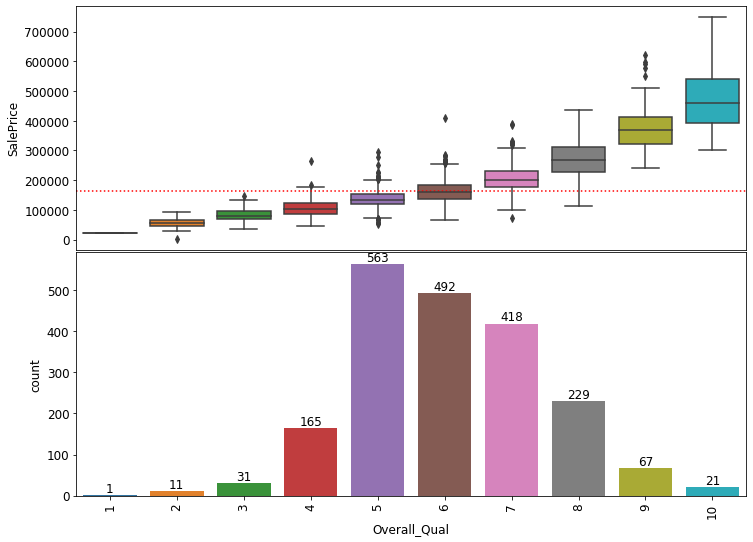

In [31]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x="Overall_Qual",
    y="SalePrice",
    data=training_data.sort_values("Overall_Qual"),
    ax=axs[0]
)

sns.countplot(
    x="Overall_Qual",
    data=training_data.sort_values("Overall_Qual"),
    ax=axs[1]
)

axs[0].axhline(
    y=training_data["SalePrice"].median(), 
    color='red',
    linestyle='dotted'
)

for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

plt.subplots_adjust(hspace=0.01)

### Question 5b <a name="q5b"></a>

Explain any conclusions you draw from the plot above, and describe how these conclusions affected the design of your model. After creating the plot, did you add/remove certain features from your model, or did you perform some other type of feature engineering? How significantly did these changes affect your rmse?

<!--
BEGIN QUESTION
name: q5b
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

The above plot analyzes the variation in sale price of a house according to the overall quality of the house, similar to how we analyzed the importance of a house being in a rich neighborhood. Similarly, I analyzed the importance of various features and then added/removed them accordingly from the model.

If we remove the Overall Quality feature from the model, the RMSE increases approximately by around 4000, which is significant enough to show the importance of the feature and justify its place in the model. Similarly, removing the new features added to the model increase the RMSE by around 10,000.

## Before You Submit

Make sure that if you run Kernel > Restart & Run All, your notebook produces the expected outputs for each cell. Congratulations on finishing the assignment!

# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 4 EXPORTED QUESTIONS -->

In [32]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('hw6.ipynb', 'hw6.pdf')
ok.submit()

Generating PDF...
Saved hw6.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw6.ipynb'.
Submit... 100% complete
Submission successful for user: aveneel@berkeley.edu
URL: https://okpy.org/cal/data100/sp20/hw6/submissions/Zz6jzQ

